In [70]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from tqdm.auto import tqdm
import time

# prediction imports
from sklearn.base import BaseEstimator, RegressorMixin
import ruptures as rpt

sns.set_style('whitegrid')

### 1. Data examination

In [2]:
data = pd.read_csv('../data/age_estimations.csv')
data.head(10)

,lemma_,count,pos,lemma,freq,pos_fr,number_of_meanings,etymology,age
0,salon@NOUN,31950,NOUN,salon,6.085083e-05,substantif,6,1550.0,470.0
1,humoriste@NOUN,2731,NOUN,humoriste,5.201365e-06,substantif,1,1578.0,442.0
2,caricaturiste@NOUN,983,NOUN,caricaturiste,1.872187e-06,substantif,1,1803.0,217.0
3,dessinateur@NOUN,9436,NOUN,dessinateur,1.797147e-05,substantif,2,1667.0,353.0
4,humoristique@ADJ,5340,ADJ,humoristique,1.017037e-05,adjectif,1,1801.0,219.0
5,organiser@VERB,107773,VERB,organiser,2.052606e-04,verbe,4,1510.0,510.0
6,humoriste@ADJ,185,ADJ,humoriste,3.523444e-07,adjectif,1,1578.0,442.0
7,comité@NOUN,70991,NOUN,comité,1.352069e-04,substantif,2,1652.0,368.0
8,mondial@ADJ,168240,ADJ,mondial,3.204239e-04,adjectif,1,1550.0,470.0
9,gus@NOUN,341,NOUN,gus,6.494565e-07,substantif,1,1954.0,66.0


In [3]:
data['rank'] = data['count'].rank(ascending=False)

In [4]:
data.shape

(10635, 10)

In [5]:
with open('../data/lemma_freq.pkl', 'rb') as f:
    lemma_freq = pickle.load(f)

# remove elements with count < 1000
lemma_freq_ = {k: v for k, v in lemma_freq.items() if v['count'] > 100}

# get all the lemmas that have same pos as in data['pos']
lemma_freq_ = {k: v for k, v in lemma_freq_.items() if v['pos'] in data['pos'].unique()}

# share of lemmas that appeared after the 1500s 
data.shape[0] / len(lemma_freq_)

0.18219039624483924

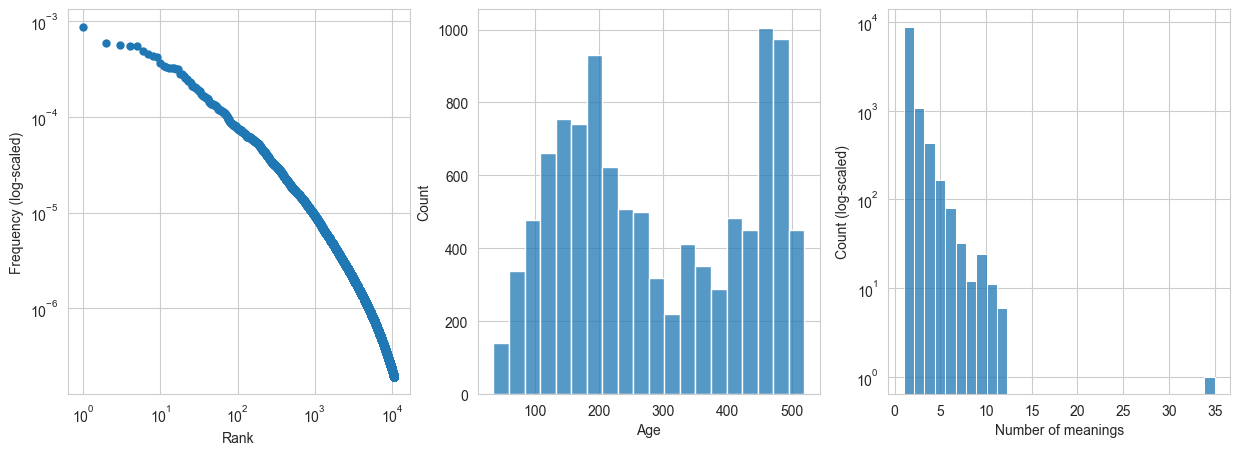

In [12]:
# plot distribuion of frequency, age, number of meanings in data on the same plot with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# first axis should be rank-frequency plot from data['count']
sns.scatterplot(x='rank', y='freq', data=data, ax=ax[0], linewidth = 0)
sns.histplot(data['age'], stat='count', ax=ax[1])
sns.histplot(data['number_of_meanings'], stat='count', ax=ax[2], bins=30)
# log scales in axes 0 and 2
# 1 axis should be log-log
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].set_xlim(1)
# remove y axis labels for axes 1 and 2
ax[0].set_ylabel('Frequency (log-scaled)')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count (log-scaled)')
ax[0].set_xlabel('Rank')
ax[1].set_xlabel('Age')
ax[2].set_xlabel('Number of meanings')
plt.show()

### 2. Get frequencies from n-gram

In [7]:
def get_ngram(query, start_year=1800, end_year=2019, 
            corpus='fr-2019'):
    time.sleep(np.random.uniform(0, 1))
    url = f'https://books.google.com/ngrams/json?content={query}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing=0'
    response = requests.get(url)
    data = response.json() 
    return data[0]['timeseries'] if data else None

In [8]:
data_1800 = data[data['etymology'] > 1800]
data_1800.shape

(4372, 10)

In [102]:
# sample 100 lemmas from data_1800
lemma_sample = data_1800.sample(500, random_state=42)

In [103]:
# get ngram frequencies for each word and save them in a long format with columns word, year, freq, etymology

freq = []
for i, row in tqdm(lemma_sample.iterrows(), total=lemma_sample.shape[0]):
    word = row['lemma']
    etymology = row['etymology']
    try:
        ngram = get_ngram(word)
        if ngram:
            for i, freq_ in enumerate(ngram):
                freq.append([word, i, freq_, etymology])
    except:
        pass

df1800_freq = pd.DataFrame(freq, columns=['word', 'year', 'freq', 'etymology'])

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df1800_freq['freq_scaled'] = df1800_freq.groupby('word')['freq'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# convert df so that each word appears only once and has a column where the frequency time-series is stored as numpy array
df1800_freq_ = df1800_freq.groupby('word')['freq_scaled'].apply(list).reset_index()
df1800_freq_['freq_scaled'] = df1800_freq_['freq_scaled'].apply(lambda x: np.array(x))
df1800_freq_['etymology'] = df1800_freq.groupby('word')['etymology'].apply(list).reset_index()['etymology'].apply(lambda x: x[0])

In [ ]:
df1800_freq_.head(10)

,word,freq_scaled,etymology
0,adventiste,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1844.0
1,agar,"[0.0, 0.0016695956281689592, 0.003927234823929...",1820.0
2,amide,"[0.01596893521387174, 0.009822511685786964, 0....",1845.0
3,anglophone,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1957.0
4,anisotropie,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1965.0
5,aquarium,"[0.02635452108836728, 0.008325654578852752, 0....",1860.0
6,arnaquer,"[0.0, 0.0, 0.009111869150305088, 0.0, 0.0, 0.0...",1835.0
7,auditorium,"[0.026824203717270345, 0.0, 0.0, 0.0, 0.0, 0.0...",1866.0
8,avant-projet,"[0.00985042664646437, 0.0, 0.0, 0.0, 0.0164858...",1845.0
9,azoture,"[0.0436548135705289, 0.04672711463090796, 0.01...",1816.0


### 3. Change point prediction

In [ ]:
class ChangePointRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, penalty=0.2, model="rbf"):
        self.penalty = penalty
        self.model = model

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        result = []

        for time_series in X:
            algo = rpt.Pelt(model=self.model).fit(time_series)
            change_point = algo.predict(pen=self.penalty)[0]
            result.append(change_point)

        return np.array(result)

    def get_params(self, deep=True):
        return {"penalty": self.penalty}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [ ]:
def prepare_data(df):
    max_length = max(len(seq) for seq in df['freq_scaled'])
    X = np.zeros((len(df), max_length))

    for i, seq in enumerate(df['freq_scaled']):
        X[i, :len(seq)] = seq

    y = np.array(df['etymology'])
    y = abs(1800 - y)
    return X, y

In [ ]:
X, y = prepare_data(df1800_freq_)

In [ ]:
# use GridSearchCV to find the best penalty value for the classifier and the best model ('rbf', 'l1, 'l2')
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': np.linspace(0, 1, 10), 'model': ['rbf', 'l1', 'l2']}

clf = GridSearchCV(ChangePointRegressor(), param_grid, cv=5, scoring='explained_variance', n_jobs=-1, )

In [ ]:
clf.fit(X, y)

GridSearchCV(cv=5, estimator=ChangePointRegressor(), n_jobs=-1,
             param_grid={'model': ['rbf', 'l1', 'l2'],
                         'penalty': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='explained_variance')

In [ ]:
clf.best_params_

{'model': 'l1', 'penalty': 0.2040816326530612}

In [ ]:
clf.best_score_

0.5462133476588388

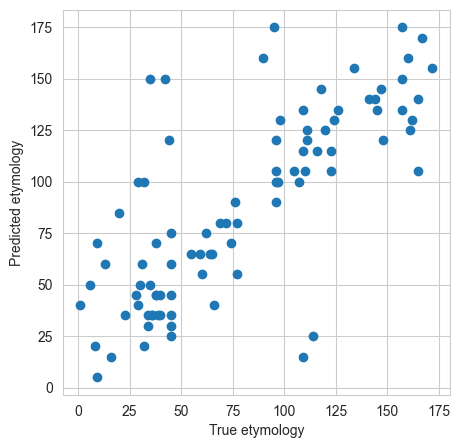

In [ ]:
# use the best parameters to fit the classifier on the whole dataset
model = ChangePointRegressor(penalty=0.2, model='l1')
model.fit(X, y)

# plot predicted vs true
y_pred = model.predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred)
plt.xlabel('True etymology')
plt.ylabel('Predicted etymology')
plt.show()

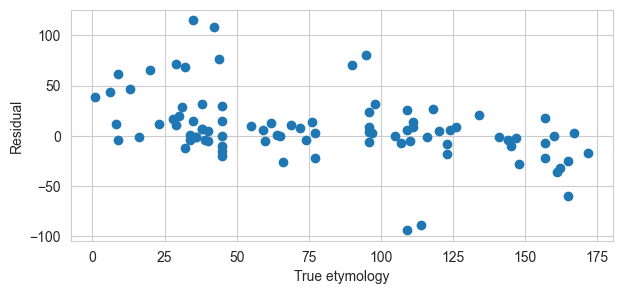

In [ ]:
# plot residuals
plt.figure(figsize=(7, 3))
plt.scatter(y, y_pred - y)
plt.xlabel('True etymology')
plt.ylabel('Residual')
plt.show()